In [1]:
# A bit of setup

import numpy as np
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [7]:
# Let's take a look at the data.
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from cs231_utils.data_utils import load_tiny_imagenet

In [8]:
# Load the actual data we want to train on based on our preprocessing script.
tiny_imagenet_dir = 'datasets/our-imagenet-100'
data_dict = load_tiny_imagenet(tiny_imagenet_dir, subtract_mean=False)

loading training data for synset 20 / 20


(array([ 251.,    0.,    0.,    0.,    0.,  251.,    0.,    0.,    0.,
           0.,  251.,    0.,    0.,    0.,    0.,  251.,    0.,    0.,
           0.,    0.,    0.,  251.,    0.,    0.,    0.,    0.,  251.,
           0.,    0.,    0.,    0.,  251.,    0.,    0.,    0.,    0.,
         251.,    0.,    0.,    0.,    0.,    0.,  251.,    0.,    0.,
           0.,    0.,  251.,    0.,    0.,    0.,    0.,  251.,    0.,
           0.,    0.,    0.,  251.,    0.,    0.,    0.,    0.,    0.,
         251.,    0.,    0.,    0.,    0.,  251.,    0.,    0.,    0.,
           0.,  251.,    0.,    0.,    0.,    0.,  251.,    0.,    0.,
           0.,    0.,    0.,  251.,    0.,    0.,    0.,    0.,  251.,
           0.,    0.,    0.,    0.,  251.,    0.,    0.,    0.,    0.,  251.]),
 array([  0.  ,   0.19,   0.38,   0.57,   0.76,   0.95,   1.14,   1.33,
          1.52,   1.71,   1.9 ,   2.09,   2.28,   2.47,   2.66,   2.85,
          3.04,   3.23,   3.42,   3.61,   3.8 ,   3.99,   4.18,   

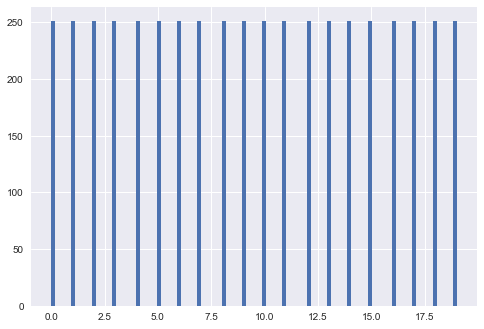

In [9]:
plt.hist(data_dict['y_train'], bins=100)

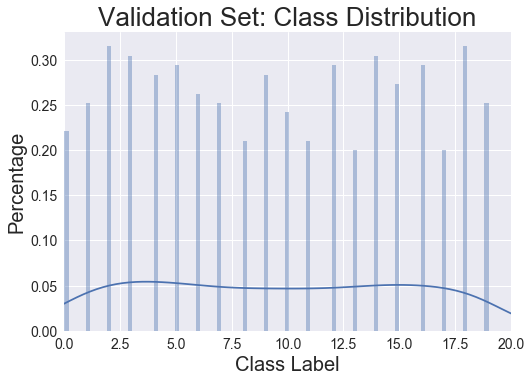

In [10]:
fig = plt.figure(1)
# We define a fake subplot that is in fact only the plot.  
plot = fig.add_subplot(111)
# We change the fontsize of minor ticks label 
plot.tick_params(axis='both', which='major', labelsize=14)
plot.tick_params(axis='both', which='minor', labelsize=14)
sns.distplot(data_dict['y_val'], bins=100, hist=True)
plt.title("Validation Set: Class Distribution", fontsize=26)
plt.ylabel("Percentage", fontsize=20)
plt.xlabel("Class Label", fontsize=20)
plt.xlim((0,20))
plt.savefig("figures/validation_class_distribution.pdf")

In [11]:
# Load the actual data we want to train on based on our preprocessing script.
monet_imagenet_dir = 'datasets/style_monet'
m_data_dict = load_tiny_imagenet(monet_imagenet_dir)

loading training data for synset 20 / 20


In [12]:
X_train = data_dict['X_train']
X_val = data_dict['X_val']
y_train = data_dict['y_train']
y_val = data_dict['y_val']

In [13]:
X_train.shape

(5020, 3, 64, 64)

In [14]:
# use pretrained ResNet and SqueezeNet models to measure baseline classification
# The are trained in the full data set.

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.models as models

import numpy as np

import timeit

In [30]:
def train(model, loader, loss_fn, optimizer, num_epochs = 1, dtype=torch.FloatTensor):
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        for t, (x, y) in enumerate(loader):
            x_var = Variable(x.type(dtype))
            y_var = Variable(y.type(dtype).long())

            scores = model(x_var)
            
            loss = loss_fn(scores, y_var)
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss.data[0]))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

def check_accuracy(model, loader, dtype=torch.FloatTensor):
    print('Checking accuracy on validation set')   
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for x, y in loader:
        x_var = Variable(x.type(dtype), volatile=True)

        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y.type(torch.LongTensor)).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [29]:
GPU = False
dtype = torch.cuda.FloatTensor if GPU else torch.FloatTensor
if GPU:
    torch.cuda.random.manual_seed(231)
else:
    torch.manual_seed(231)
loss_fn = nn.CrossEntropyLoss().type(dtype)

In [18]:
# Pre-trained
resnet18_trained = models.resnet18(pretrained=True).type(dtype)
squeezenet_trained = models.squeezenet1_0(pretrained=True).type(dtype)

In [19]:
# Custom squeezenet model
class Fire(nn.Module):

    def __init__(self, inplanes, squeeze_planes,
                 expand1x1_planes, expand3x3_planes):
        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes,
                                   kernel_size=1)
        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes,
                                   kernel_size=3, padding=1)
        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.squeeze_activation(self.squeeze(x))
        return torch.cat([
            self.expand1x1_activation(self.expand1x1(x)),
            self.expand3x3_activation(self.expand3x3(x))
        ], 1)
    
class SqueezeNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(SqueezeNet, self).__init__()
        self.num_classes = num_classes
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            Fire(64, 16, 64, 64),
            Fire(128, 16, 64, 64),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            Fire(128, 32, 128, 128),
            Fire(256, 32, 128, 128),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            Fire(256, 48, 192, 192),
            Fire(384, 48, 192, 192),
            Fire(384, 64, 256, 256),
            Fire(512, 64, 256, 256),
        )
        # Final convolution is initialized differently from the rest
        final_conv = nn.Conv2d(512, num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            final_conv,
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1)
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m is final_conv:
                    init.normal(m.weight.data, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x.view(x.size(0), self.num_classes)

In [20]:
# Random weights default
resnet18_default = models.resnet18(num_classes=20).type(dtype)
squeezenet_default = SqueezeNet(num_classes=20).type(dtype)

In [21]:
# Load original data.
tiny_imagenet_dir = 'datasets/our-imagenet-100'
data_dict = load_tiny_imagenet(tiny_imagenet_dir)
X_train, y_train, X_val, y_val = (dtype(data_dict['X_train']),
                                  dtype(data_dict['y_train'].astype(float)),
                                  dtype(data_dict['X_val']),
                                  dtype(data_dict['y_val'].astype(float)))

loading training data for synset 20 / 20


In [22]:
train_dset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dset,
                    batch_size=64)
val_dset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dset,
                    batch_size=64)

In [23]:
optimizer = optim.Adam(resnet18_default.parameters(), lr=1e-3)

In [ ]:
# Constant to control how frequently we print train loss
print_every = 100

train(squeezenet_default, train_loader, loss_fn, optimizer, num_epochs=30, dtype=dtype)

Starting epoch 1 / 30
Starting epoch 2 / 30

In [31]:
check_accuracy(squeezenet_default, val_loader, dtype=dtype)

Checking accuracy on validation set
Got 27 / 501 correct (5.39)
